In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

import skimage
from skimage import io
from skimage.transform import resize

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import seaborn as sn

Links
 - https://drive.google.com/drive/folders/1bhnMJ8NbCa-qw53EKy-olZp3cJKZU_jc
 - https://drive.google.com/drive/folders/1X5HdFvgWJOVtA-GxBLr1K_0FHJS2RZcZ
 - https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9528382&tag=1

In [2]:
train_dir = os.path.join(sys.path[0], 'train/')
test_dir = os.path.join(sys.path[0], 'test/')

In [3]:
def readHieroglyphData(data_dir):
    images = []
    targets = []
    for hier in os.listdir(data_dir):
        if not os.path.isdir(os.path.join(data_dir, hier)):
            continue
        for img in os.listdir(os.path.join(data_dir, hier)):
            targets.append(hier)
            images.append(np.asarray(io.imread(os.path.join(data_dir, hier, img))))
    return images, targets

In [4]:
def resizeImageData(data, image_size):
    resize_func = lambda img: resize(img, (image_size, image_size), anti_aliasing=True)
    resized_data = list(map(resize_func, data))
    return resized_data

In [5]:
images_train, targets_train = readHieroglyphData(train_dir)

In [6]:
images_test, targets_test = readHieroglyphData(test_dir)

In [7]:
images_train = resizeImageData(images_train, 100)
images_test = resizeImageData(images_test, 100)

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(targets_train)
print(list(le.classes_))

['D2', 'D21', 'D36', 'D4', 'D46', 'D58', 'E23', 'E34', 'F31', 'F35', 'G1', 'G17', 'G43', 'I10', 'I9', 'M17', 'M23', 'N35', 'O1', 'O34', 'O4', 'O49', 'Q1', 'Q3', 'R4', 'R8', 'S29', 'S34', 'U7', 'V13', 'V28', 'V30', 'V31', 'W11', 'W24', 'X1', 'X8', 'Y1', 'Y5', 'Z1']


In [9]:
labels_train = le.transform(targets_train)
labels_test = le.transform(targets_test)

In [10]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

num_labels = len(le.classes_)
x_train = np.expand_dims(images_train, -1) / 255.
x_test = np.expand_dims(images_test, -1) / 255.

y_train = to_categorical(labels_train, num_labels)
y_test = to_categorical(labels_test, num_labels)

x_train.shape

(2467, 100, 100, 1)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D, GlobalAveragePooling2D

model = Sequential()

#first block
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), input_shape=(100, 100, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Activation('relu'))

#second block
model.add(SeparableConv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(SeparableConv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Activation('relu'))

#third block
model.add(SeparableConv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(SeparableConv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Activation('relu'))

#fourth block
model.add(SeparableConv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(SeparableConv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Activation('relu'))

#fifth block
model.add(SeparableConv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.15))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(num_labels, activation='softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
activation (Activation)      (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 49, 49, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 49, 49, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])

run_hist = model.fit(x_train, y_train,
                     epochs=10,
                     validation_data=(x_test, y_test),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)])

Epoch 1/10
78/78 [==============================] - 9s 74ms/step - loss: 1.8351 - accuracy: 0.5326 - val_loss: 3.6545 - val_accuracy: 0.0472
Epoch 2/10
78/78 [==============================] - 5s 63ms/step - loss: 0.7351 - accuracy: 0.8034 - val_loss: 3.6826 - val_accuracy: 0.0157
Epoch 3/10
78/78 [==============================] - 5s 63ms/step - loss: 0.4539 - accuracy: 0.8772 - val_loss: 3.7353 - val_accuracy: 0.0157
Epoch 4/10
78/78 [==============================] - 5s 64ms/step - loss: 0.2910 - accuracy: 0.9133 - val_loss: 3.9321 - val_accuracy: 0.0157
Epoch 5/10
78/78 [==============================] - 5s 63ms/step - loss: 0.2815 - accuracy: 0.9189 - val_loss: 4.0571 - val_accuracy: 0.0157
Epoch 6/10
78/78 [==============================] - 5s 64ms/step - loss: 0.2462 - accuracy: 0.9283 - val_loss: 4.0385 - val_accuracy: 0.0157
Epoch 7/10
78/78 [==============================] - 5s 63ms/step - loss: 0.1429 - accuracy: 0.9623 - val_loss: 4.4075 - val_accuracy: 0.0157
Epoch 8/10
78

In [14]:
scores = model.evaluate(x_test, y_test)

print("Loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))

20/20 [==============================] - 0s 19ms/step - loss: 5.6278 - accuracy: 0.0126
Loss: 5.627755641937256
Accuracy: 0.012598425149917603


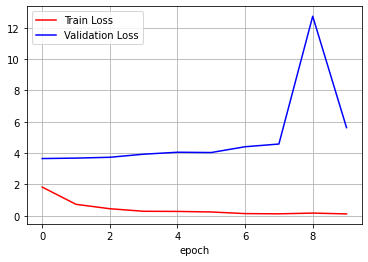

In [15]:
plt.plot(run_hist.history['loss'], color='r', label='Train Loss')
plt.plot(run_hist.history['val_loss'], color='b', label='Validation Loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

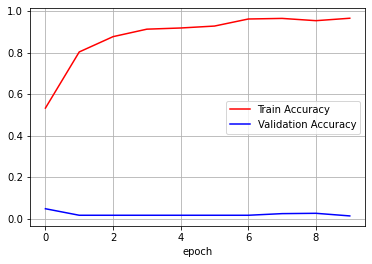

In [16]:
plt.plot(run_hist.history['accuracy'], color='r', label='Train Accuracy')
plt.plot(run_hist.history['val_accuracy'], color='b', label='Validation Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

[Text(0.5, 123.0, 'Predicted label'), Text(168.0, 0.5, 'True label')]

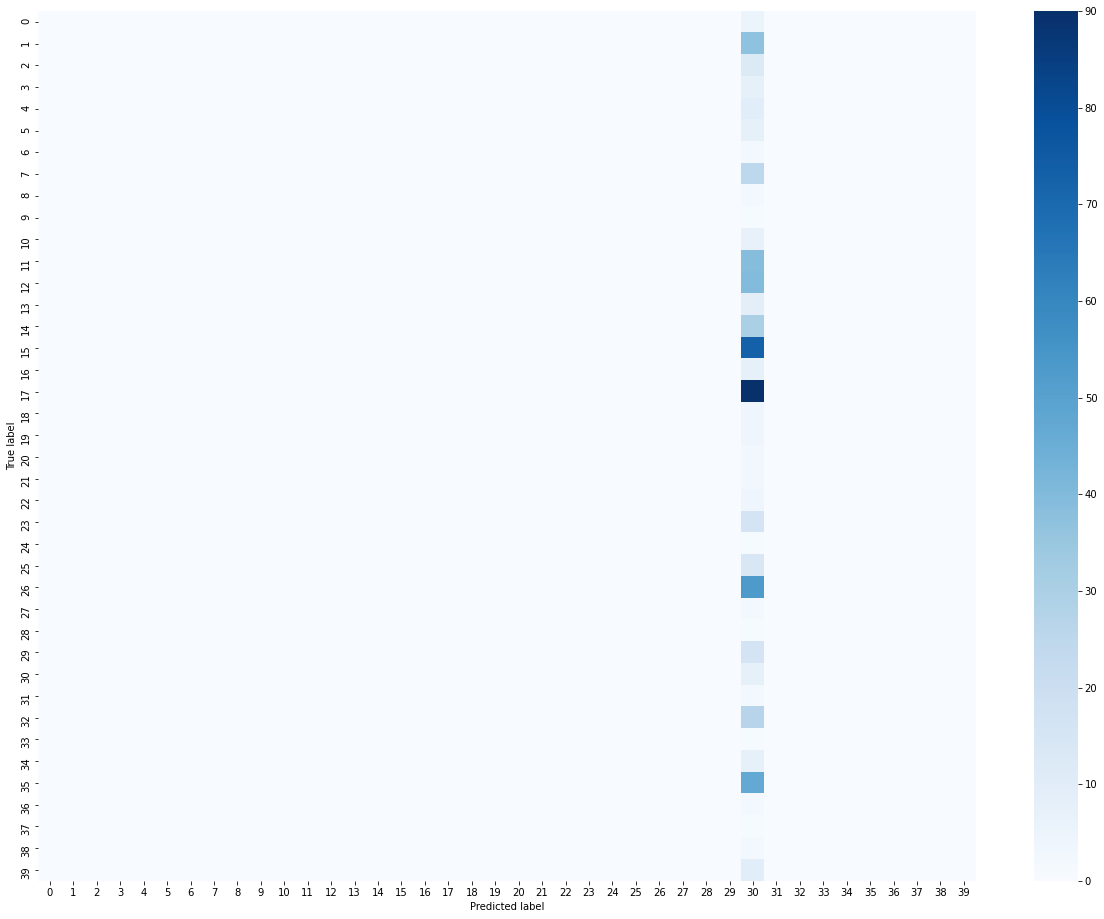

In [17]:
y_pred = [np.argmax(i) for i in model.predict(x_test)]
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm)

plt.figure(figsize = (21,16))
ax = sn.heatmap(df_cm, cmap="Blues")
ax.set(xlabel='Predicted label', ylabel='True label')

## Modified model

In [18]:
images_train, targets_train = readHieroglyphData(train_dir)
images_test, targets_test = readHieroglyphData(test_dir)

In [19]:
labels_train = le.transform(targets_train)
labels_test = le.transform(targets_test)

In [20]:
num_labels = len(le.classes_)
x_train = np.expand_dims(images_train, -1) / 255.
x_test = np.expand_dims(images_test, -1) / 255.

y_train = to_categorical(labels_train, num_labels)
y_test = to_categorical(labels_test, num_labels)

x_train.shape

(2467, 75, 50, 1)

In [21]:
model = Sequential()

#first block
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), input_shape=(75, 50, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Activation('relu'))

#second block
model.add(SeparableConv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(SeparableConv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Activation('relu'))

#third block
model.add(SeparableConv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(SeparableConv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Activation('relu'))

#fourth block
model.add(SeparableConv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.15))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(num_labels, activation='softmax'))

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])

run_hist = model.fit(x_train, y_train,
                     epochs=10,
                     validation_data=(x_test, y_test),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)])

Epoch 1/10
78/78 [==============================] - 5s 38ms/step - loss: 1.9759 - accuracy: 0.4909 - val_loss: 3.6272 - val_accuracy: 0.0583
Epoch 2/10
78/78 [==============================] - 2s 29ms/step - loss: 0.8558 - accuracy: 0.7799 - val_loss: 3.6690 - val_accuracy: 0.0220
Epoch 3/10
78/78 [==============================] - 2s 29ms/step - loss: 0.4834 - accuracy: 0.8715 - val_loss: 3.6744 - val_accuracy: 0.0220
Epoch 4/10
78/78 [==============================] - 2s 30ms/step - loss: 0.3418 - accuracy: 0.9068 - val_loss: 3.9776 - val_accuracy: 0.0220
Epoch 5/10
78/78 [==============================] - 2s 29ms/step - loss: 0.3232 - accuracy: 0.9060 - val_loss: 4.0561 - val_accuracy: 0.0220
Epoch 6/10
78/78 [==============================] - 2s 29ms/step - loss: 0.2307 - accuracy: 0.9319 - val_loss: 3.5177 - val_accuracy: 0.0394
Epoch 7/10
78/78 [==============================] - 2s 29ms/step - loss: 0.2460 - accuracy: 0.9368 - val_loss: 1.1958 - val_accuracy: 0.6236
Epoch 8/10
78

In [23]:
scores = model.evaluate(x_test, y_test)

print("Loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))

20/20 [==============================] - 0s 9ms/step - loss: 0.2337 - accuracy: 0.9449
Loss: 0.23373672366142273
Accuracy: 0.9448819160461426


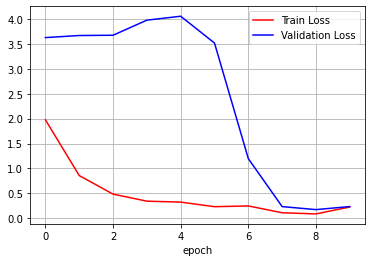

In [24]:
plt.plot(run_hist.history['loss'], color='r', label='Train Loss')
plt.plot(run_hist.history['val_loss'], color='b', label='Validation Loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

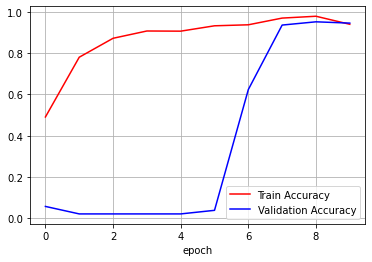

In [25]:
plt.plot(run_hist.history['accuracy'], color='r', label='Train Accuracy')
plt.plot(run_hist.history['val_accuracy'], color='b', label='Validation Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

[Text(0.5, 123.0, 'Predicted label'), Text(168.0, 0.5, 'True label')]

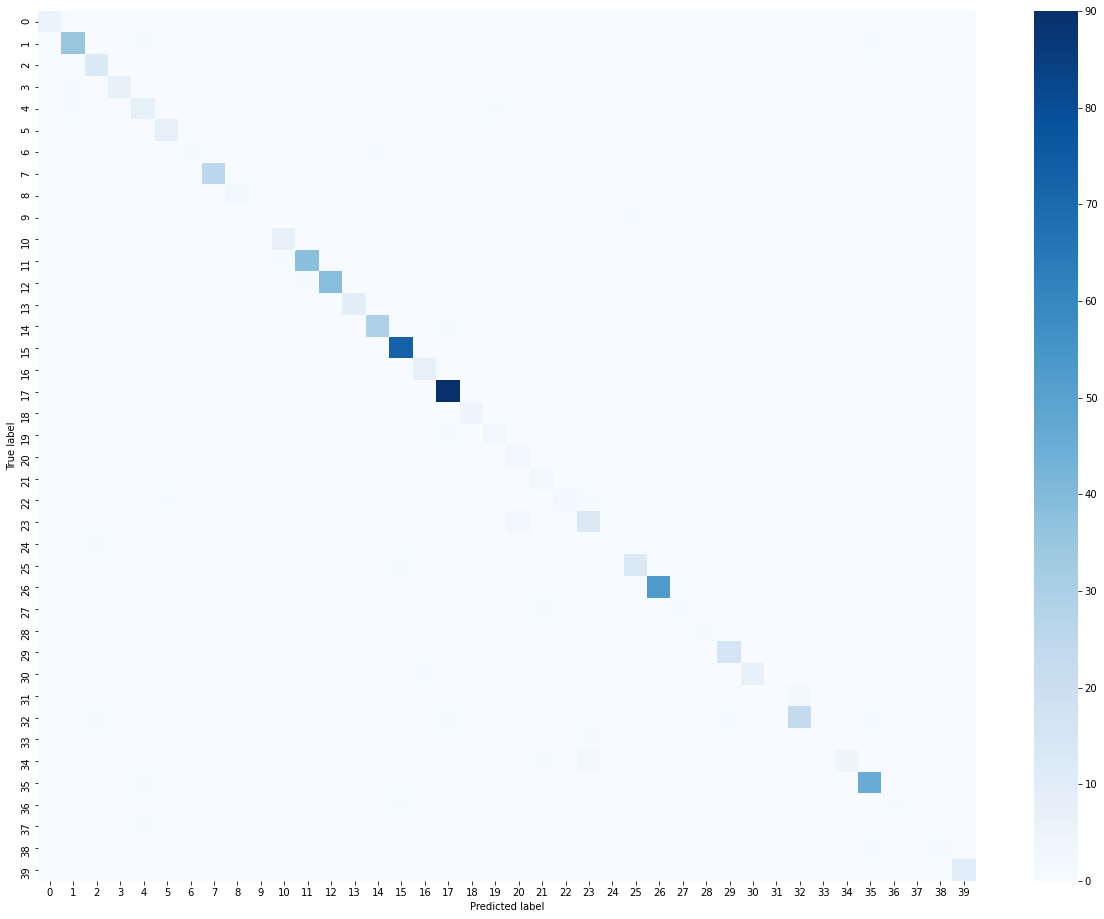

In [26]:
y_pred = [np.argmax(i) for i in model.predict(x_test)]
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm)

plt.figure(figsize = (21,16))
ax = sn.heatmap(df_cm, cmap="Blues")
ax.set(xlabel='Predicted label', ylabel='True label')